# Imports

Analyze mistake-types, on the Story Task.

In [1]:
import pandas as pd
import numpy as np
from itertools import chain
import ast
## plotting
import matplotlib.pyplot as plt
import statsmodels.api as sm
import seaborn as sns

## specify to print all outputs, not just the cell's first output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
# Read in the data
accuracy = pd.read_csv('3b_accuracy.csv')
# subset to Story Task
accuracy = accuracy[~accuracy["names_flag"]]

In [15]:
# Note: this data includes the wrong_submissions of participants who then got that question correct, no correction required.
# They entered some wrong_submissions but then entered a correct submission.
# accuracy[accuracy["accuracy"] == True][["wrong_submissions", "list_of_strings"]]


In [3]:
# Function for safely parsing list_of_strings, a list which unfortunately gets stringified when written to csv then reloaded.
def ensure_list(val):
    if isinstance(val, str):
        try:
            return ast.literal_eval(val)
        except (ValueError, SyntaxError):
            return []
        return val  # already a list

# Output 1: Exploratory Table. View some mistakes per target_pair.
Table with two columns: left column is target_pair.
Right column is a truncated unsorted array, providing a sampling of the kinds of mistakes people typed (for that target-pair).

In [5]:
# Initialize dictionary: 
mistakes_by_question = {}
# each key is a target-pair; the value is a list of mistakes for that target-pair.


# Iterate over each unique target_pair
for target_pair in accuracy["target_pair"].unique():
    # Filter to rows for this current_pair
    df = accuracy[accuracy["target_pair"] == target_pair].copy()

    # After reading from CSV
    df["list_of_strings"] = df["list_of_strings"].apply(ensure_list)

    column_of_lists_of_strings = df.list_of_strings
    flat_list = list(chain.from_iterable(column_of_lists_of_strings))

    # store in dictionary
    mistakes_by_question[target_pair] = flat_list
    
# convert to dataframe
mistakes_by_question = pd.DataFrame(list(mistakes_by_question.items()), columns=["target_pair", "mistakes"])
mistakes_by_question

,target_pair,mistakes
0,rake_leaves,"[sandbar, leavew, s, box, hive, sandbox, leave..."
1,leaves_stream,"[ste, river, river, float, , , bees, strea,, m..."
2,stream_sandbar,"[bees, mi, ou, , mouse, comb, honey, sand, san..."
3,sandbar_bees,"[bea, mouse, hivebox, hive, hivebox, s, leav, ..."
4,bees_hivebox,"[hv, iv, , beehive, comb, mouse, honey, beehiv..."
5,hivebox_mouse,"[water, ni, l, water, mou, , , sprout, leaves,..."
6,mouse_sprouts,"[shoots, sprout, w, autumn, winter, honey, bee..."
7,dryland_pond,"[p, treehouse, hou, , bamboo, field, pondb, po..."
8,pond_bamboo,"[treehouse, coi, , stakes, coins, fountain, tr..."
9,bamboo_stakes,"[treehouse, sp, take, , treehouse, stoke, , st..."


# Output 2: Create 2 lists, which enable mistakes to be sorted into 3 types.

They allow mistakes to be sorted into 3 types: "typos", "transposition error", and "non-typo but not in list".

In [64]:
# Create list of not_typos.  
# not_typos includes both "transposition errors" (non-typo, is a target word, but in wrong order) and "non-typo but not a target word".

# flatten mistakes_by_question (df) into a list:
all_mistakes = [item for sublist in mistakes_by_question["mistakes"] for item in sublist]
len(all_mistakes)

# remove duplicates
all_mistakes_unique = list(dict.fromkeys(all_mistakes))
len(all_mistakes_unique)

# for mistake in all_mistakes_unique:
#     print(mistake)

# manually cleaned subset
not_typos = [
    "sandbar", "box", "hive", "sandbox", "stream", "river", "float", "bees",
    "mop", "mouse", "trees", "comb", "honey", "sand", "leaves", "water", "silt",
    "sprout", "hivebox", "fall", "rake", "hives", "beehives", "bee", "beehive",
    "honeycomb", "white", "shoots", "autumn", "winter", "shop", "trap", "cheese",
    "fur", "peas", "treehouse", "bamboo", "field", "dryravine", "drypond", "brush",
    "stakes", "sticks", "tag", "ravine", "coins", "fountain", "coinfountain",
    "coin", "thicket", "strike", "stake", "stick", "pond", "strikes",
    "dryland", "treetag", "tags", "tree", "kids", "drying", "guard",
    "lookout", "fish"
]
len(not_typos)

357

151

64

In [65]:
# Make keys_list, so I can filter the non-typos into "transposition errors" vs "non-typo but not a target word".
keys_list = list(mistakes_by_question["target_pair"])
keys_list = list(chain.from_iterable(key.split("_") for key in keys_list))
keys_list = list(dict.fromkeys(keys_list))
keys_list

['rake',
 'leaves',
 'stream',
 'sandbar',
 'bees',
 'hivebox',
 'mouse',
 'sprouts',
 'dryland',
 'pond',
 'bamboo',
 'stakes',
 'treehouse',
 'tag',
 'coins',
 'fountain']

# Roadmap for the rest of subsection: Results Relevant to Hypothesis 2.


The not_typos list & targets_list enable sorting each participants' errors, or each question's errors, into 3 categories of mistakes:
"typos", "transposition error", and "non-typo but not in list".
The 2nd will be evaluated for "cutting in line" vs whether it also goes in the other direction, and the 3rd will be evaluated for whether these non-typos are semantically similar to the target word (which could also be framed as a compression artifact), associationally similar to something in the story (demonstrating some compressed representation of the story), or neither-- not clearly related to the target word, anything in the story, and perhaps only semantically/associationally connected to the cue word at best.

Next up: Confusion Matrix.

Later, I'll also sort mistakes_by_participant into 3 types, b/c "Definitely. That's what connects to [old] H2. I use a percentage of non-typos as the regression's predicted variable; both filtering-lists are used."


# Sort Mistake Types by Question into 3 types, for Confusion Matrix:

It would also be cool to have a "percentage of errors that were each type, by question" in the bar chart-- hopefully that bar chart of question difficulty. Aha! I will need to bring that in. It belongs here. Have both versions-- the controlled for order, with no stacks by error type, and the no controlled for order bar chart (where I will put the stacks by error type). 2 BAR CHARTS AS 2 ADDITIONAL OUTPUTS.

In [66]:
# sort the mistakes_by_question dataframe into 3 mistake types, and add these as columns. (keep duplicates, within the new lists for each column.)
mistakes_by_question['typos'] = mistakes_by_question['mistakes'].apply(
    lambda mistake_list: [mistake for mistake in mistake_list if mistake not in not_typos])
mistakes_by_question['target_intrusions'] = mistakes_by_question['mistakes'].apply(
    lambda mistake_list: [mistake for mistake in mistake_list if mistake in keys_list])
mistakes_by_question['non_typo_non_target'] = mistakes_by_question['mistakes'].apply( # this column will be manually sorted; it's just an intermediate column
    lambda mistake_list: [mistake for mistake in mistake_list if (mistake not in keys_list) and (mistake in not_typos)])
# additional columns added below, via manual sorting

# initial check, just to make sure the list comprehensions worked right:

# make jupyter notebook output be extra wide to show everything in each column, rather than truncating it:
# pd.set_option('display.max_columns', None)     # Show all columns
# pd.set_option('display.max_colwidth', None)    # Don't truncate column values

# # reset display options, afterward:
# pd.reset_option('display.max_columns')
# pd.reset_option('display.expand_frame_repr')

# mistakes_by_question_copy = mistakes_by_question.drop(columns=['mistakes','typos','transposition_errors'])
# mistakes_by_question_copy

Then I sorted 'non_typo_non_position_errors' into an additional 4 categories:

In [67]:
mistakes_by_question['genericized_target'] = [
    [],
    ["river", "river", "float"],
    ["sand", "sand", "sand", "sand", "sand", "silt", "silt"],
    ["bee"],
    ["beehive", "beehive", "hive", "beehive", "hive", "hive", "hive", "hives", "hive", "beehive"],
    [],
    ["shoots", "sprout", "sprout", "sprout", "sprout", "sprout", "sprout", "sprout", "peas"],
    ["drypond"],
    ["thicket"],
    ["stake", "stake", "stick"],
    ["tree", "tree", "treetag", "treetag",],
    ["tags"],
    ["coin", "coin", "coin", "coin"],
    []
]
mistakes_by_question['alternate_detail'] = [
    [],
    [],
    ["water"],
    ["hive", "hive", "hive", "hives", "beehives",],
    ["water", "water", "water", "comb", "honey", "honey", "honeycomb", "honey"],
    [],
    [],
    ["field", "dryravine", "dryravine", "brush", "sticks", "ravine"],
    ["ravine"],
    [],
    ["tags", "kids", "drying"],
    ["guard"],
    ["guard", "kids", "lookout"],
    [],
]
mistakes_by_question['detail_intrusions'] = [
    ["box", "hive"],
    [],
    ["hive", "sprout", "fall", "comb", "honey", "hive", "sprout", "fall"],
    ["honey"],
    [],
    ["water", "water", "sprout", "white"],
    ["autumn", "winter", "honey", "honey", "shop", "hive", "honey", "honeycomb"],
    [],
    ["coinfountain", "coin", "coin"],
    ["coin"],
    ["coin"],
    [],
    ["fish"],
    [],
]
mistakes_by_question['unrelated_to_stories'] = [
    ["sandbox"],
    ["mop", "trees", "trees"],
    ["river", "river"],
    ["river"], 
    ["trees"], 
    [], 
    ["trap", "cheese", "fur"], 
    [], 
    ["strike"], 
    ["strike", "strike", "strikes"], 
    [], 
    [], 
    [],
    []
]

# RESUME HERE: Confusion matrix

In [100]:
# ok, what does a confusion matrix need?
# I should sort the wrong responses by question.

# ok good, I want target_pair as one column of the confusion matrix.
# Now I want to add a column for each word in the list:



type(mistakes_by_pair_df['mistakes'].iloc[0])

type(keys_list[0])
keys_list
mistakes_by_pair_df

list

str

['rake',
 'leaves',
 'stream',
 'sandbar',
 'bees',
 'hivebox',
 'mouse',
 'sprouts',
 'dryland',
 'pond',
 'bamboo',
 'stakes',
 'treehouse',
 'tag',
 'coins',
 'fountain']

,target_pair,mistakes
0,rake_leaves,"[sandbar, leavew, s, box, hive, sandbox, leave..."
1,leaves_stream,"[ste, river, river, float, , , bees, strea,, m..."
2,stream_sandbar,"[bees, mi, ou, , mouse, comb, honey, sand, san..."
3,sandbar_bees,"[bea, mouse, hivebox, hive, hivebox, s, leav, ..."
4,bees_hivebox,"[hv, iv, , beehive, comb, mouse, honey, beehiv..."
5,hivebox_mouse,"[water, ni, l, water, mou, , , sprout, leaves,..."
6,mouse_sprouts,"[shoots, sprout, w, autumn, winter, honey, bee..."
7,dryland_pond,"[p, treehouse, hou, , bamboo, field, pondb, po..."
8,pond_bamboo,"[treehouse, coi, , stakes, coins, fountain, tr..."
9,bamboo_stakes,"[treehouse, sp, take, , treehouse, stoke, , st..."


In [21]:
confusion_df = mistakes_by_pair_df.copy()
for key in keys_list:
    confusion_df[key] = confusion_df["mistakes"].apply(lambda list: list.count(key))
# confusion_df

NameError: name 'mistakes_by_pair_df' is not defined

In [22]:
# Optional: remove the 'mistakes' column before plotting
plot_df = confusion_df.drop(columns=['mistakes'])

# Set figure size and style
plt.figure(figsize=(12, 10))
sns.set(style="whitegrid")

# # Plot the heatmap
# ax = sns.heatmap(
#     plot_df,
#     cmap="Blues",         # Color scheme: dark blue = high count
#     linewidths=0.5,       # Light lines between cells
#     linecolor='gray',
#     cbar_kws={"label": "Mistake Count"},
#     square=True           # Keep cells square
# )

# # Add labels and title
# plt.xlabel("Mistake Type (valid word)")
# plt.ylabel("Target Pair")
# plt.title("Confusion Matrix of Mistakes (Valid but Misplaced Words)")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

NameError: name 'confusion_df' is not defined

In [23]:

# # Drop the 'mistakes' column (which contains lists)
# plot_df = confusion_df.drop(columns=["mistakes"])

# # Ensure all values are numeric
# plot_df = plot_df.apply(pd.to_numeric, errors='coerce')

# # Optional: replace NaN with 0
# plot_df = plot_df.fillna(0)

# # Plot the heatmap
# plt.figure(figsize=(12, 10))
# sns.heatmap(
#     plot_df,
#     cmap="Blues",
#     linewidths=0.5,
#     linecolor='gray',
#     cbar_kws={"label": "Mistake Count"},
#     square=True
# )
# plt.xlabel("Mistaken Word (valid but wrong location)")
# plt.ylabel("Target Pair")
# plt.title("Confusion Matrix of Word Confusions")
# plt.xticks(rotation=45, ha='right')
# plt.tight_layout()
# plt.show()

# Still need to polish these, and subdivide the non-order-controlled one into a stack.
careful with how it loads in data-- that would overwrite mine.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# read in accuracy.csv as a dataframe
accuracy = pd.read_csv('3b_accuracy.csv')

story_qs = accuracy[~accuracy["names_flag"]]
name_qs = accuracy[accuracy["names_flag"]]

# # Make bar chart, showing which questions were missed most, for the Stories Task.
# # I want to group by question_k, and for each question_k, count the number correct.
plt.figure(figsize=(10, 6))
story_qs.groupby("target_pair")["accuracy"].sum().sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Target Pair")
plt.ylabel("Number Correct")
plt.title("Story Task: Accuracy per Target Pair")
plt.show()

# plot by list position
# plt.figure(figsize=(10,6))
# story_qs.groupby("pair_index")["accuracy"].sum().sort_values(ascending=False).plot(kind="bar")
# plt.xticks(rotation=90)
# plt.xlabel("Target Pair")
# plt.ylabel("Number Correct")
# plt.title("Story Task: Accuracy per Target Pair")
# plt.show()

# ok, there's a strong order-effect. The later questions are harder.
# Can I control for order-effect? Fit a linear trend, then subtract that to "detrend":
import numpy as np
import statsmodels.api as sm

# Step 1: Average accuracy per pair_index
avg_acc_by_order = story_qs.groupby("pair_index")["accuracy"].mean().reset_index()

# Step 2: Fit a linear regression: accuracy ~ pair_index
X = avg_acc_by_order["pair_index"]
X = sm.add_constant(X)  # add intercept
y = avg_acc_by_order["accuracy"]
model = sm.OLS(y, X).fit()

# Step 3: Predict the order effect (linear trend)
avg_acc_by_order["order_effect"] = model.predict(X)

# Step 4: Map that order effect back to the original dataframe
order_effects_dict = dict(zip(avg_acc_by_order["pair_index"], avg_acc_by_order["order_effect"]))
story_qs["order_effect"] = story_qs["pair_index"].map(order_effects_dict)

# Step 5: Detrended accuracy (residuals)
story_qs["detrended_accuracy"] = story_qs["accuracy"] - story_qs["order_effect"]

## plot again, by list position, but detrended this time:
plt.figure(figsize=(10,6))
story_qs.groupby("target_pair")["detrended_accuracy"].sum().sort_values(ascending=False).plot(kind="bar")
plt.xticks(rotation=90)
plt.xlabel("Target Pair")
plt.ylabel("Number Correct")
plt.title("Story Task: Accuracy per Target Pair, Detrended for Order Effect")
plt.show()


# Misc. Questions. Subsume into ^^ writeup, about mistakes_by_question.
future tests: were a lot of people using the "acronym" stratgey,
and that's what caused the learning effect?
how many of these are just typos?
how many are a valid word, but wrong place? (acronym mistake). heatmap would show.
how many are valid idea-- semantically similar-- yet not quite right?
how many are "cutting in line"-- wrong location-- semantically similar or correct?

# Mistake Types by Participant (Hypothesis 2) 
Do I want to sort mistakes_by_participant into 3 types? Definitely. That's what connects to H2. I use a percentage of non-typos as the regression's predicted variable; both filtering-lists are used.

In [43]:
mistakes_by_participant = {}
# each key is a nth_participant, and the value is a list of mistakes.

# Iterate over each unique target_pair
for nth_participant in accuracy["nth_participant"]:
    # Filter to rows for this current_pair
    df = accuracy[accuracy["nth_participant"] == nth_participant].copy()

    # After reading from CSV
    df["list_of_strings"] = df["list_of_strings"].apply(ensure_list)

    column_of_lists_of_strings = df.list_of_strings
    flat_list = list(chain.from_iterable(column_of_lists_of_strings))

    # store in dictionary
    mistakes_by_participant[nth_participant] = flat_list

<Figure size 600x400 with 0 Axes>

Text(0.5, 0, 'Stories Task Score')

Text(0, 0.5, 'Wrong Location % of Non-Typo')

Text(0.5, 1.0, 'Wrong Location Errors by Object')

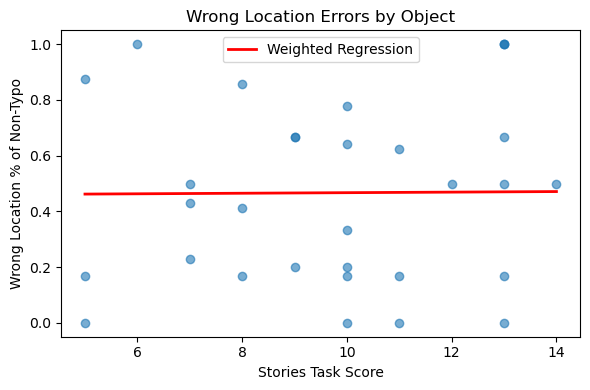

                                  WLS Regression Results                                  
Dep. Variable:     wrong_location_pct_of_non_typo   R-squared:                       0.000
Model:                                        WLS   Adj. R-squared:                 -0.034
Method:                             Least Squares   F-statistic:                  0.001885
Date:                            Wed, 04 Jun 2025   Prob (F-statistic):              0.966
Time:                                    11:37:29   Log-Likelihood:                -7.6150
No. Observations:                              31   AIC:                             19.23
Df Residuals:                                  29   BIC:                             22.10
Df Model:                                       1                                         
Covariance Type:                        nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
-----------

In [76]:
# Now sort each participant's mistakes.

def len_not_typos(mistakes):
    return len([mistake for mistake in mistakes if mistake in not_typos])

def len_wrong_location(mistakes):
    return len([mistake for mistake in mistakes if mistake in keys_list])

# make the mistakes_by_participant dictionary into a df
participant_mistakes_df = pd.DataFrame(list(mistakes_by_participant.items()), columns=["nth_participant", "mistakes"])

# add columns
participant_mistakes_df["total_mistakes"] = participant_mistakes_df["mistakes"].apply(len)
participant_mistakes_df["non_typo_mistakes"] = participant_mistakes_df["mistakes"].apply(len_not_typos)
participant_mistakes_df["wrong_location_mistakes"] = participant_mistakes_df["mistakes"].apply(len_wrong_location)
participant_mistakes_df["wrong_location_pct_of_non_typo"] = participant_mistakes_df["wrong_location_mistakes"]/participant_mistakes_df["non_typo_mistakes"]

# accuracy by test type (names or objects) and by nth_participant
accuracy_type_nth = (
    accuracy.groupby(['names_or_objects', 'nth_participant'])['accuracy'].sum()
    .unstack('names_or_objects')
    .rename_axis(columns=None)  # Flatten column index. Unstack & Pivot create a Multi-column Index, trying to keep names_or_objects as an overarching name for names and objects
)

merged = pd.merge(
    participant_mistakes_df,
    accuracy_type_nth,
    on="nth_participant",
    how="left"  # or "inner", depending on whether you want to keep unmatched rows
)

# Drop NaNs
clean_df = merged[(merged['wrong_location_pct_of_non_typo'].notna()) & (clean_df['nth_participant'] != 46)]
# also tried dropping participant 46, who only achieved 1 correct answer on the Story Task. I could try examining if their self-report questions
# responded "sleepy". If not, I think that would be a clear indicator that they simply weren't trying. However, I have no way to do this methodically across my dataset; what 
# I'm doing resembles cherry-picking data, and should instead be treated as a sensitivity analysis to outliers. Especially outliers which are weighted extra-heavily.
# I am not overly concerned about removing this data point from the BLUP plot, since it was there assigned a 1 maximum likelihood on the Story Task, showing that the participant random intercept helped isolate the effect of including that participant to just that participant. (it would still however be dragging the distribution)

# Define X and y
X = clean_df["objects"]
y = clean_df["wrong_location_pct_of_non_typo"]
weights = clean_df["non_typo_mistakes"]

# Add constant to X for intercept
X_with_const = sm.add_constant(X)

# Fit weighted least squares model
wls_model = sm.WLS(y, X_with_const, weights=weights)
results = wls_model.fit()

# Predict y values for the regression line
x_pred = np.linspace(X.min(), X.max(), 100)
x_pred_with_const = sm.add_constant(x_pred)
y_pred = results.predict(x_pred_with_const)


plt.figure(figsize=(6, 4))
plt.scatter(X, y, alpha=0.6)
plt.plot(x_pred, y_pred, color='red', linewidth=2, label='Weighted Regression')
plt.xlabel("Stories Task Score")
plt.ylabel("Wrong Location % of Non-Typo")
plt.title("Wrong Location Errors by Object")
plt.legend()
plt.tight_layout()
plt.show()

print(results.summary())

# Can you help me plot a regression line? I want the "wrong_location_pct_of_non_typo" to be weighted by merged["non_typo_mistakes"], since
# the participants with a high objects score tended to have fewer non_typo_mistakes.



# hypothesis: high objects score correlates with low wrong_location_pct


In [75]:
clean_df.sort_values('objects')

,nth_participant,mistakes,total_mistakes,non_typo_mistakes,wrong_location_mistakes,wrong_location_pct_of_non_typo,objects
2,7,"[sandbar, mouse, beehive, p, treehouse, hou, ,...",12,8,7,0.875000,5
25,43,"[leavse, , leas, ve, , trap]",6,1,0,0.000000,5
9,20,"[river, float, , , sand, shop, hive, bees]",8,6,1,0.166667,5
28,47,"[stream, bess, , e, bess, , stakes]",7,2,2,1.000000,6
7,18,"[river, river, bees, honey, honey, treehouse, ...",7,7,3,0.428571,7
20,33,"[bees, hivebox, honey, honeycomb, pon, , tag, ...",13,8,4,0.500000,7
15,27,"[sandbox, bees, bees, hive, hive, mouse, dryra...",20,13,3,0.230769,7
3,10,"[leavew, s, bees, mi, ou, , mouse, comb, honey...",25,17,7,0.411765,8
22,38,"[slt, it, sl, p, slit, hives, bees, h, bes, eh...",17,6,1,0.166667,8
21,37,"[mop, mouse, bees, hivebo, , coins, tag, pond,...",10,7,6,0.857143,8


In [60]:
merged.sort_values('objects')

,nth_participant,mistakes,total_mistakes,non_typo_mistakes,wrong_location_mistakes,wrong_location_pct_of_non_typo,objects
27,46,"[trees, trees, fall, trees, b, stake]",6,5,0,0.000000,1
2,7,"[sandbar, mouse, beehive, p, treehouse, hou, ,...",12,8,7,0.875000,5
25,43,"[leavse, , leas, ve, , trap]",6,1,0,0.000000,5
9,20,"[river, float, , , sand, shop, hive, bees]",8,6,1,0.166667,5
28,47,"[stream, bess, , e, bess, , stakes]",7,2,2,1.000000,6
15,27,"[sandbox, bees, bees, hive, hive, mouse, dryra...",20,13,3,0.230769,7
7,18,"[river, river, bees, honey, honey, treehouse, ...",7,7,3,0.428571,7
20,33,"[bees, hivebox, honey, honeycomb, pon, , tag, ...",13,8,4,0.500000,7
3,10,"[leavew, s, bees, mi, ou, , mouse, comb, honey...",25,17,7,0.411765,8
22,38,"[slt, it, sl, p, slit, hives, bees, h, bes, eh...",17,6,1,0.166667,8


In [61]:
merged.columns

Index(['nth_participant', 'mistakes', 'total_mistakes', 'non_typo_mistakes',
       'wrong_location_mistakes', 'wrong_location_pct_of_non_typo', 'objects'],
      dtype='object')

In [ ]:
# Before trying that for each participant, put all words in list. Filter for "is a dictionary word". Filter for "correct but wrong location". Find percentage.


# next, create wrong_place, by filtering using isin()
wrong_place_stories = {}
for pair_key, mistakes_list in wrong_by_pair.items():
    wrong_place_stories[pair_key] = [mistake for mistake in mistakes_list if mistake in keys_list]
    
# find length of wrong_place_stories:
wrong_place_list = []
for pair_key, mistakes_list in wrong_place_stories.items():
    wrong_place_list.append(mistakes_list)
wrong_place_list = list(chain.from_iterable(wrong_place_list))




In [ ]:
# CONSIDER IF I CAN GET ANYTHING OUT OF THIS ABOUT THE PARTICIPANTS; IF NOT, MOVE BACK TO WORDS.
# I think stories task would be good at detecting non-reason-linkers (wrong order) vs reason-linkers (semantically similar.)
# so, higher stories score is expected to be correlated with a higher percentage of your answers being semantically similar, rather than wrong-order.
# and higher echo score is expected to be correlated with the opposite.

# originally, I got each participant's random intercept + fixed effects to get their predicted accuracy,
# for a question on the stories task, in an interf or non-interf stories task location.

# so, higher stories score is expected to be correlated with a higher percentage of your answers being semantically similar, rather than wrong-order.
# think about it this way: what's the x axis? stories score, out of 14. What's the y axis? % of their stories-task errors that were incorrect order, vs incorrect semantically.
# that runs into a difficulty: needing to unweight the high-accuracy stories scores, since they had hardly any errors in which to try to detect a correlation.
# also, I'm still leery of the fact that the stories task (total score) is a binomial distribution. Ok, totally valid to use their BLUP instead of their composite stories score. But for a quick and dirty analysis, just use their composite stories score.
# hmm. It's a tree of possible outcomes, rather than a binary logit, now. I bet that's got some cool stats to it. (That's how you'd handle de-weighting the %s of the high-scorers.)





# Make this into an appendix. Add the stories.

Yes — if the LaTeX export didn’t preserve your table formatting and you want to manually paste into Overleaf using tabular, then generating each row row-wise from a DataFrame is a good approach.

Here’s a Jupyter-friendly script that:

Converts each row of a DataFrame into LaTeX tabular syntax,

Skips the column headers,

Adds & between columns, \\ at the end of each row,

Adds \hline between rows,

And escapes LaTeX special characters (like _).



In [ ]:
import pandas as pd

def escape_latex(s):
    """Escape underscores and other LaTeX special characters."""
    if isinstance(s, str):
        return s.replace('_', r'\_').replace('%', r'\%').replace('&', r'\&')
    return s

def dataframe_to_latex_rows(df):
    lines = []
    for _, row in df.iterrows():
        escaped_row = [escape_latex(str(cell)) for cell in row]
        line = ' & '.join(escaped_row) + r' \\'
        lines.append(r'\hline' + '\n' + line)
    return '\n'.join(lines)

# Example usage:
# Let's say your DataFrame is called `mistakes_by_question`
# and you only want specific columns:
selected_df = mistakes_by_question[['cue_target', 'typos']]

latex_rows = dataframe_to_latex_rows(selected_df)
print(latex_rows)


In [74]:
# make jupyter notebook output be extra wide to show everything in each column, rather than truncating it:
pd.set_option('display.max_columns', None)     # Show all columns
pd.set_option('display.max_colwidth', None)    # Don't truncate column values

mistakes_by_question['cue_target'] = mistakes_by_question['target_pair'] 
mistakes_by_question['wrong_target'] = mistakes_by_question['transposition_errors']

from IPython.display import display, HTML

html = mistakes_by_question[['cue_target', 'typos', 'wrong_target']].to_html()

display(HTML(f"""
<div style="max-width: 600px; overflow-x: auto;">
  {html}
</div>
"""))

,cue_target,typos,wrong_target
0,rake_leaves,"[leavew, s, leaves', leavse, , leas, ve, , leavs, e]","[sandbar, stream, stream]"
1,leaves_stream,"[ste, , , strea,]","[bees, mouse]"
2,stream_sandbar,"[mi, ou, , si, , , idk, spo, ro, spor, slt, it, sl, p, slit]","[bees, mouse, bees, leaves, bees, bees, mouse, hivebox, bees, hivebox, bees, bees, hivebox, hivebox]"
3,sandbar_bees,"[bea, s, leav, , , hiveboz, x, hivebo, , h, bes, ehi, , bess, , e, bess, ]","[mouse, hivebox, hivebox, rake, stream, mouse, hivebox, bees, mouse, hivebox, hivebox]"
4,bees_hivebox,"[hv, iv, , hib, v, san, , , b]","[mouse, mouse, leaves, mouse]"
5,hivebox_mouse,"[ni, l, mou, , ]","[leaves, sandbar, stream]"
6,mouse_sprouts,"[w, sorout, sprour, ts, , spor, leave, , , , xhee, , , sh, , p, pease, , , , ]","[bees, bees, rake, leaves, rake]"
7,dryland_pond,"[p, hou, , pondb, pong, d, pong, d, dyrpo, , pong, pon, , rvin, ravinw]","[treehouse, bamboo, bamboo, stakes, tag]"
8,pond_bamboo,"[coi, , coi, , , bambo, c, ravn, l, bab, co]","[treehouse, stakes, coins, fountain, treehouse, stakes, coins, tag, stakes, tag]"
9,bamboo_stakes,"[sp, take, , stoke, , stoke, stokes]","[treehouse, treehouse, tag, tag, pond, tag, dryland]"


In [75]:
mistakes_by_question['story'] = [
    "A pile of autumn leaves, and a little kid proudly managing to rake them together— the rake’s taller than he is.",
    "A few autumn leaves, floating down the stream in a line",
    "A stream has deposited a sandbar of fresh silt, perfectly flat, like a shelf formed just a few inches above the water.",
    "The stream has deposited a sandbar of fresh silt, perfectly flat, like a shelf formed just a few inches above the water. It’s sunny there, and humid. There are bees landing, perhaps attracted by the water which wicks up through the soil. Maybe that’s the water which they carry back to their hivebox.",
    "It’s a hot day, and there are some honeybees flying back to their hivebox. It’s shaped like a white cube, painted white to reflect the summer heat. There are frames of hexagonal honeycomb hanging inside, and also some frames mostly full of young bees— that’s where the young bees live, one to a cell, until they’re old enough to fly outside the hive. Today, the older bees are bringing them water.",
    "The beehive, now in winter, with the hexagonal comb cells full of honey. It’s cold, so the bees pack into a dense ball around just one or two of the hanging comb-frames; they metabolize honey to keep warm. There’s a mouse who realizes the bees can’t leave their warm huddle to defend the other frames of honey, and happily sets up shop in the far corner for the winter.",
    "A row of sprouts, bright green against the black soil of a garden bed. It’s early spring, and they’re just a few inches tall. They’re snap pea sprouts, and a mouse has just found them; he hasn’t had anything green to eat all winter.",
    "A small pond in a ravine, surrounded by green thickets of brush. The summers are dry here, and farther up the banks of the pond there is only dry grass, golden & sunbleached.",
    "The bamboo thicket grows right up to the edge of the pond. Years ago, the groundskeepers planted it in the ravine around the pond, since they saw how well the other varieties of brush have been doing. The bamboo’s been thriving there over since, and helps keep the pond shaded.",
    "A bamboo thicket, about 12 feet tall, dense and impenetrable. Each year during summertime, the groundskeepers cut back a section of the thicket to make bamboo stakes. First they set it all in piles to dry out over the summer, and later they’ll turn it all into bamboo stakes. (Stakes can be stuck in the ground next to other plants, and help support them as they grow.)",
    "The kids playing treehouse tag want to make it easier to sneak up on the treehouse. Over the course of the summer they drag big piles of the (slowly drying) bamboo stakes over towards the treehouse, into half-woven shelters and hiding places.",
    "A group of kids came up with a game they love to play called “treehouse tag”. One kid guards the tree, and the others try to sneak past the guard and tag it. There’s also a treehouse way up in the branches, where the guard’s partner (the “lookout”) can get a better view of the surroundings and yell out if there’s anyone trying to sneak up. Together they defend the tree, and switch off now and then so the guard doesn’t get tired.",
    "Treehouse tag was getting boring; it was kind of a stalemate, since it was so easy for the guard and the lookout to defend the tree. So the other kids made a new rule: the guard has to go out and try to tag the other kids first, and if they get caught they have to go jump into the fountain and bring back a coin. That makes the guard and the lookout want to try to tag as many of the kids as possible— either so they can get a bunch of coins and have enough to buy bubblegum (but get bad luck), or so they can get ALL the good luck from the coins by getting to throw them back into the fountain. The other kids like the new rule too, since it makes it easier to tag the tree because the guard’s always getting lured away. If someone tags it, they get to be the new guard and pick a friend as the lookout, and share the growing pile of coins so long as the new pair can defend them.",
    "A fountain in the middle of a pool. The pool is aboveground at about knee height, with beautiful rockwork sides made from interlocking stones, stacked and mortared together. They form a bench at the perfect height for sitting; the mist from the fountain is at your back, and your feet are still on the gravel path. The bottom of the fountain is covered in coins: mostly pennies, dimes, and quarters. People toss them in for good luck, and the koi fish don’t seem to mind.",
]

In [77]:
mistakes_by_question[['cue_target', 'semantically_similar_to_target', 'story', 'alt_detail_from_story']]

,cue_target,semantically_similar_to_target,story,alt_detail_from_story
0,rake_leaves,[],"A pile of autumn leaves, and a little kid proudly managing to rake them together— the rake’s taller than he is.",[]
1,leaves_stream,"[river, river, float]","A few autumn leaves, floating down the stream in a line",[]
2,stream_sandbar,"[sand, sand, river, river, sand, sand, water, sand, silt, silt]","A stream has deposited a sandbar of fresh silt, perfectly flat, like a shelf formed just a few inches above the water.",[]
3,sandbar_bees,"[hive, honey, hive, hive, hives, beehives, bee]","The stream has deposited a sandbar of fresh silt, perfectly flat, like a shelf formed just a few inches above the water. It’s sunny there, and humid. There are bees landing, perhaps attracted by the water which wicks up through the soil. Maybe that’s the water which they carry back to their hivebox.",[]
4,bees_hivebox,"[beehive, comb, honey, beehive, hive, beehive, honey, hive, hive, hive, honeycomb, hives, hive, honey, beehive]","It’s a hot day, and there are some honeybees flying back to their hivebox. It’s shaped like a white cube, painted white to reflect the summer heat. There are frames of hexagonal honeycomb hanging inside, and also some frames mostly full of young bees— that’s where the young bees live, one to a cell, until they’re old enough to fly outside the hive. Today, the older bees are bringing them water.","[water, water, water]"
5,hivebox_mouse,[],"The beehive, now in winter, with the hexagonal comb cells full of honey. It’s cold, so the bees pack into a dense ball around just one or two of the hanging comb-frames; they metabolize honey to keep warm. There’s a mouse who realizes the bees can’t leave their warm huddle to defend the other frames of honey, and happily sets up shop in the far corner for the winter.",[]
6,mouse_sprouts,"[shoots, sprout, sprout, sprout, sprout, sprout, sprout, sprout, peas]","A row of sprouts, bright green against the black soil of a garden bed. It’s early spring, and they’re just a few inches tall. They’re snap pea sprouts, and a mouse has just found them; he hasn’t had anything green to eat all winter.",[]
7,dryland_pond,[drypond],"A small pond in a ravine, surrounded by green thickets of brush. The summers are dry here, and farther up the banks of the pond there is only dry grass, golden & sunbleached.","[field, dryravine, dryravine, brush, sticks, ravine]"
8,pond_bamboo,[thicket],"The bamboo thicket grows right up to the edge of the pond. Years ago, the groundskeepers planted it in the ravine around the pond, since they saw how well the other varieties of brush have been doing. The bamboo’s been thriving there over since, and helps keep the pond shaded.",[ravine]
9,bamboo_stakes,"[stake, stake, stick]","A bamboo thicket, about 12 feet tall, dense and impenetrable. Each year during summertime, the groundskeepers cut back a section of the thicket to make bamboo stakes. First they set it all in piles to dry out over the summer, and later they’ll turn it all into bamboo stakes. (Stakes can be stuck in the ground next to other plants, and help support them as they grow.)",[]


In [71]:
mistakes_by_question[['cue_target', 'alt_detail_from_OTHER_story_OR_semantically_similar_to_OTHER_target', 'words_unrelated_to_test']]

,cue_target,alt_detail_from_OTHER_story_OR_semantically_similar_to_OTHER_target,words_unrelated_to_test
0,rake_leaves,"[box, hive]",[sandbox]
1,leaves_stream,[],"[mop, trees, trees]"
2,stream_sandbar,"[hive, sprout, fall, comb, honey, hive, sprout, fall]",[]
3,sandbar_bees,[river],[]
4,bees_hivebox,[],[trees]
5,hivebox_mouse,"[water, water, sprout, white]",[]
6,mouse_sprouts,"[autumn, winter, honey, honey, shop, hive, honey, honeycomb]","[trap, cheese, fur]"
7,dryland_pond,[],[]
8,pond_bamboo,"[coinfountain, coin, coin]",[strike]
9,bamboo_stakes,[coin],"[strike, strike, strikes]"
